# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

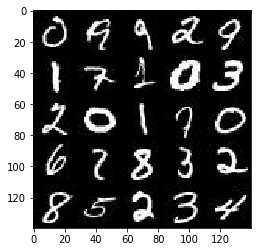

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

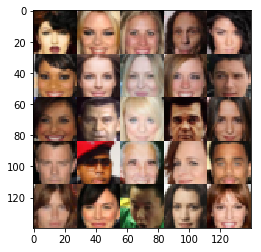

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
               
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.7481
Epoch 1/2... Discriminator Loss: 2.1182... Generator Loss: 6.7122
Epoch 1/2... Discriminator Loss: 2.1090... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.5661
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 2.9156
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 3.9549
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 1.4138
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 2.8403
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 2.1351


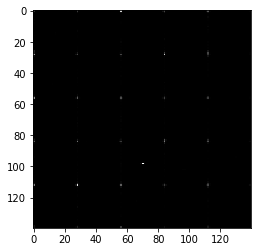

Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 1.8623
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.0713
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.3898
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 1.2631
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 2.0097
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 2.4870
Epoch 1/2... Discriminator Loss: 1.9542... Generator Loss: 4.1014


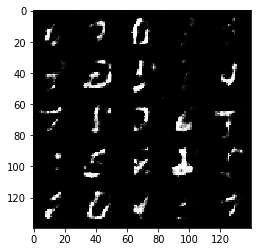

Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 1.2229
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.7993


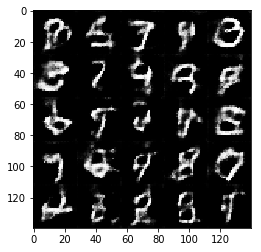

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 1.5292
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 1.3561
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 1.6809
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 2.0224
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 1.3699
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.5839


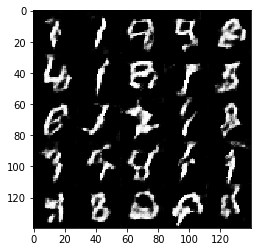

Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.6622
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 1.1403
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.6491
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 2.3454
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 2.6045
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.7342
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 1.0443


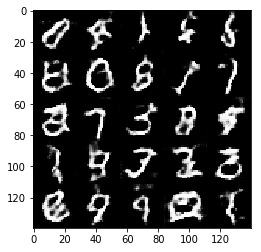

Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 2.2462
Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 2.1265
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.7577
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.6352
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 2.2243
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.3564
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 2.0911
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.7284
Epoch 1/2.

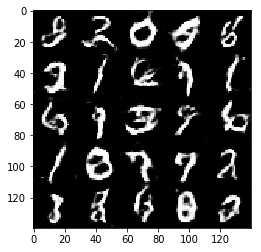

Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.7360
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 2.6606
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.9687
Epoch 1/2... Discriminator Loss: 1.9373... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9323
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.7629
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.5867
Epoch 1/2... Discriminator Loss: 0.8881... Generator Loss: 1.1511
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.9437


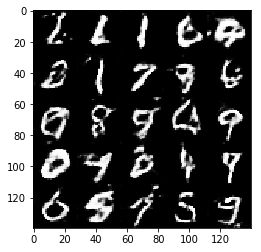

Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 3.0012
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.5611
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 1.1236
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.9169
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 2.0920
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.2067
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.5497


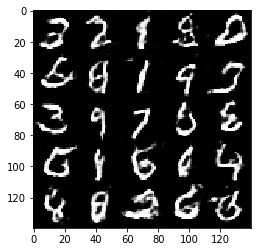

Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.7225
Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.6353
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 2.5237
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 2.4735
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.6095
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.7598
Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 2.0568


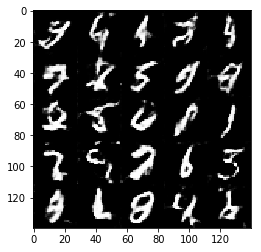

Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 2.7171
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 2.0196
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 1.4044
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 2.2681
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 2.2155
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 3.0592
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.7325
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 1.3985
Epoch 2/2... Discriminator Loss: 0.7387... Generator Loss: 2.2983


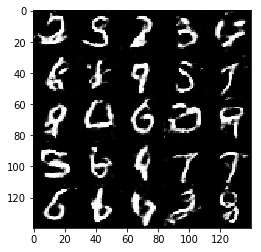

Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.7558
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.6376
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.5615
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 2.8515
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 2.1269
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 2.7271
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 2.0669


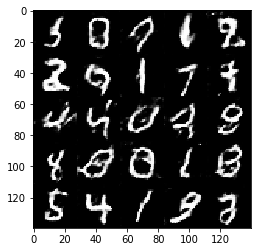

Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 1.8205
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 3.2786
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 3.7180
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 1.6647
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.9737
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.8344
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 2.8620


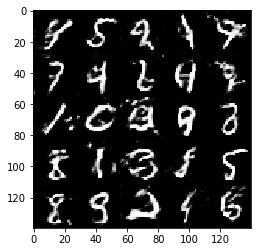

Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.7582
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 2.5417
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 3.2060
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.9105
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 2.2722
Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 2.0856
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.8447
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 2.9503
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 2.1893


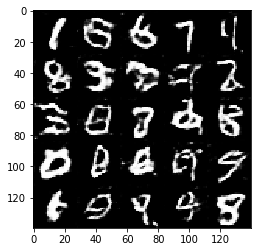

Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 2.1806
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.8569
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 3.9753
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.7177
Epoch 2/2... Discriminator Loss: 0.5538... Generator Loss: 2.1816
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.8521
Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 2.1695
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 2.5392
Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 2.8699


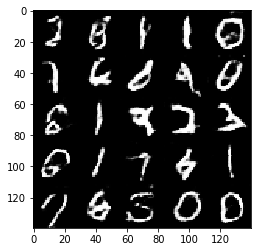

Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 2.3925
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.8189
Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 2.8463
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.8442
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.6125
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 2.4563


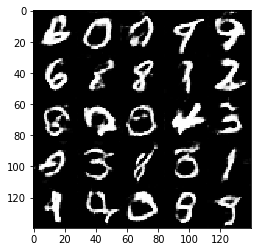

Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 2.8572
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.5358
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 2.2148
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 2.7341
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 3.6409
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 2.7384
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.7224
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 2.1999


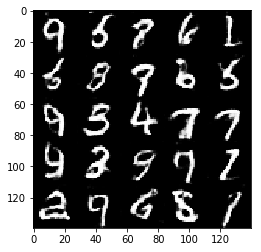

Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.5863
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 2.5581
Epoch 2/2... Discriminator Loss: 0.5372... Generator Loss: 2.3267
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 2.3595
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 2.0555
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 2.1324


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.5357
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.8453
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.7149
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.7553
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 4.1986
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 3.7920
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 4.3477
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 3.0376
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.3650
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.0470


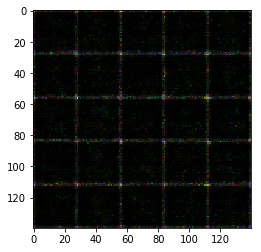

Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.6361
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 3.1091
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.9472
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.5263
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.1010
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.7515
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 4.0264
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 4.1500
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.9478
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 5.0421


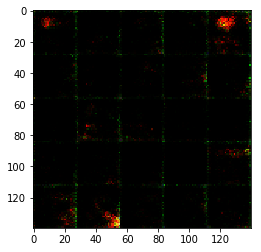

Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 3.4324
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 3.2585
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 4.5282
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 4.8267
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.4547
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.5129
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 5.0267
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 5.6232
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.9781
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 5.1395


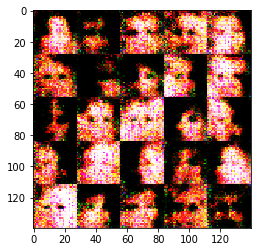

Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.2308
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 4.5370
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.6339
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.8556
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 2.5410
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 4.8300
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 3.8719
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 4.7408
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 4.6505
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.6358


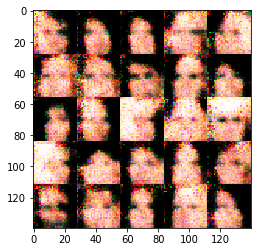

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 3.3055
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 3.4062
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.6898
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.5159
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 5.2826
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 3.8171
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.6371
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 4.0694
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 5.0940
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 4.0149


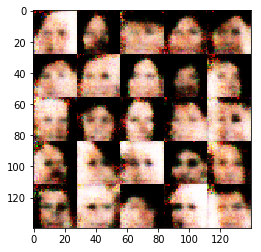

Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 4.7435
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.7866
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.1864
Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 5.1866
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.7366
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 4.7287
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 4.4974
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 3.1630
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 5.1567
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 3.5058


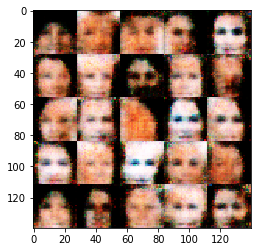

Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 5.2810
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 3.0328
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 8.0055
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.9709
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 3.3693
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 4.9340
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.8769
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 4.3482
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 2.9111


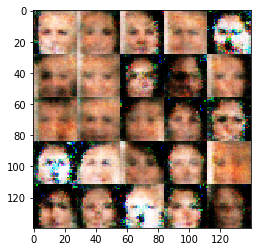

Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 3.5553
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 3.8011
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.9930
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 2.9523
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 3.7242
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 3.8945
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 4.0461
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.5152
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 4.2467
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.5199


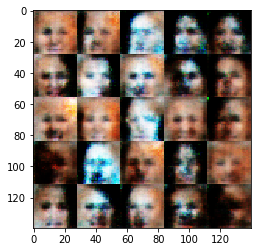

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.9860
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.7459
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 4.0942
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 2.6923
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 3.6646
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.9567
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.2567
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.9543
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.3995


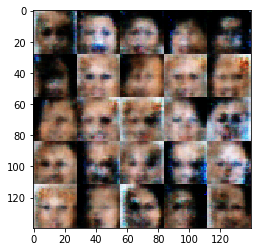

Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 2.9078
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 2.2166
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.6740
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 3.7083
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 3.1055
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 3.2622
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.1700
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.9628
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 3.5445


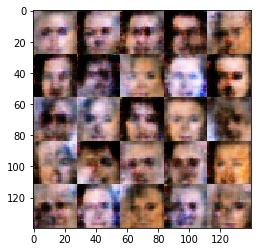

Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 2.1621
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 2.3421
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.9773
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 3.5141
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 2.1935
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 2.0364
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 2.6429
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 2.4602


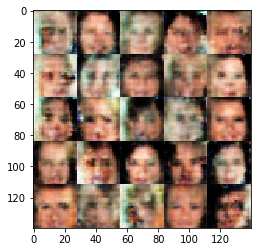

Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 2.3220
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 2.6530
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 2.1127
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 2.1745
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.3432
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.1030
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.8366


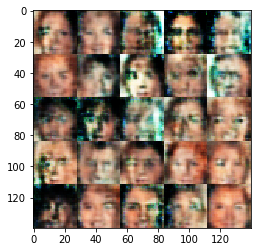

Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.2241
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.9959
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.4034
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.7601
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 2.1444
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 2.8336
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 2.1657
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.4856


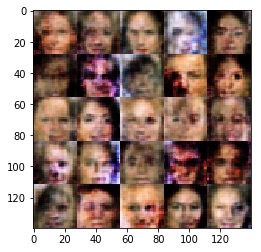

Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.4450
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.8595
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 2.2181
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 2.2266
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 2.6802


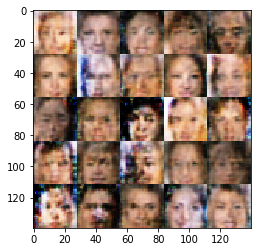

Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.4477
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 2.0095
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 2.4051
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.7086
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.7093


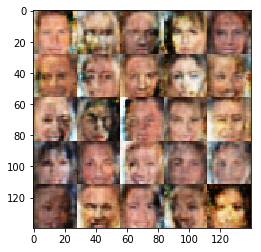

Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 2.0314
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.8824
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.6693
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 2.4406


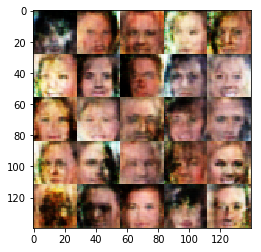

Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.8449
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 2.0486
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.5880
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2208


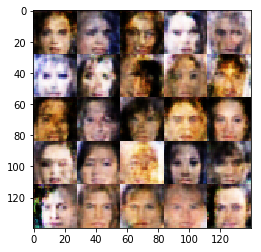

Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.8705
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 2.3156
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 2.2310
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 2.4317
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 2.1303


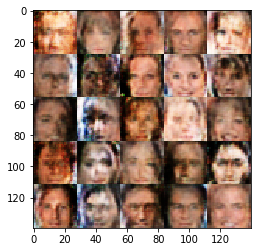

Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.8178
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.8071
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.6429


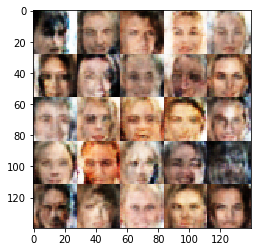

Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.8541


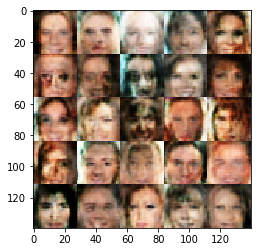

Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.9231
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 2.3363
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.7025
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.9161
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.4370
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.8589


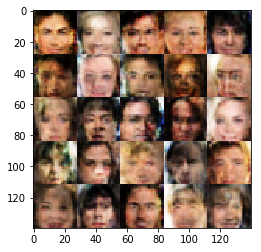

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 2.0594
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.5752


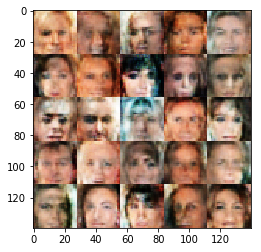

Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.6919
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.7405


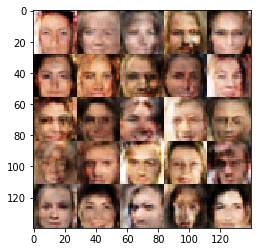

Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.7797
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.5666


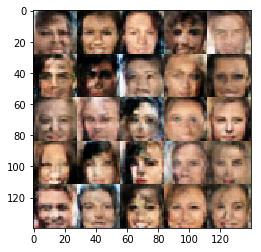

Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.1989
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 2.0113


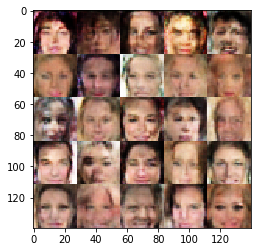

Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.7680
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.9771
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.7884
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.9870


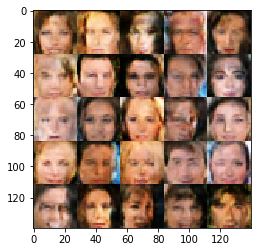

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.8672
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.9531
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 2.0923
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.8237
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0250


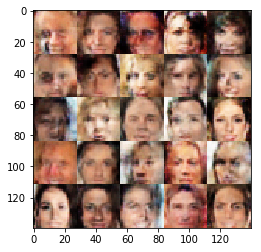

Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.7507
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.9523
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.8353
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4413


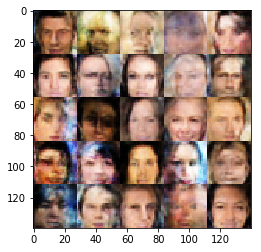

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.4848
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 2.2928
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.7222
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.9427
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.6310


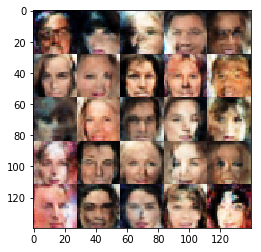

Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.7739
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.9268
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 2.4923
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 2.0946
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.6200


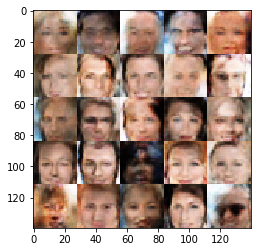

Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 2.1097
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.8501
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.8581
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.6381
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.3771


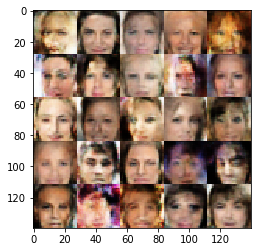

Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.5750
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 2.1471


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。